## CaseCraft: The Analytics Sprint – Project 12  
### Cab Route Efficiency Analysis  
**Subheading:** Evaluating cab trip performance using synthetic geospatial and trip metadata to optimize route efficiency.

---

### Project Goals

- Simulate cab trip data with pickup/dropoff coordinates, time, and fare  
- Engineer features: trip distance, duration, speed, fare per km  
- Visualize route paths and efficiency metrics  
- Cluster trips by efficiency and time of day  
- Build regression model to predict route efficiency  
- Plot confusion matrix for binned efficiency categories  
- Summarize insights for urban mobility optimization

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, confusion_matrix

np.random.seed(42)

n_trips = 1000
pickup_lat = np.random.uniform(19.0, 19.3, n_trips)
pickup_lon = np.random.uniform(72.8, 73.0, n_trips)
drop_lat = pickup_lat + np.random.normal(0, 0.01, n_trips)
drop_lon = pickup_lon + np.random.normal(0, 0.01, n_trips)
duration_min = np.random.uniform(5, 45, n_trips)
fare = duration_min * np.random.uniform(0.8, 1.5, n_trips)
time_of_day = np.random.choice(['Morning', 'Afternoon', 'Evening', 'Night'], n_trips)

distance_km = [geodesic((pickup_lat[i], pickup_lon[i]), (drop_lat[i], drop_lon[i])).km for i in range(n_trips)]
speed_kmph = np.array(distance_km) / (duration_min / 60)
fare_per_km = fare / np.array(distance_km)

df = pd.DataFrame({
    'pickup_lat': pickup_lat,
    'pickup_lon': pickup_lon,
    'drop_lat': drop_lat,
    'drop_lon': drop_lon,
    'duration_min': duration_min,
    'fare': fare,
    'distance_km': distance_km,
    'speed_kmph': speed_kmph,
    'fare_per_km': fare_per_km,
    'time_of_day': time_of_day
})

In [8]:
df.head(10)

,pickup_lat,pickup_lon,drop_lat,drop_lon,duration_min,fare,distance_km,speed_kmph,fare_per_km,time_of_day
0,19.112362,72.837027,19.103582,72.855736,28.971971,33.697981,2.195522,4.546855,15.348502,Afternoon
1,19.285214,72.908380,19.276945,72.912276,25.548314,21.353686,1.002762,2.354977,21.294878,Evening
2,19.219598,72.974589,19.217333,72.965906,16.527381,15.915884,0.946836,3.437336,16.809548,Morning
3,19.179598,72.946445,19.183271,72.951791,5.258574,6.017919,0.693943,7.917850,8.672060,Evening
4,19.046806,72.961312,19.055941,72.934955,24.849569,25.276104,2.952939,7.129956,8.559643,Afternoon
5,19.046798,72.931757,19.038767,72.931790,16.425040,15.229864,0.889067,3.247724,17.130171,Night
6,19.017425,72.938455,19.032352,72.941734,34.384332,39.641455,1.687950,2.945441,23.484965,Evening
7,19.259853,72.969839,19.257142,72.979082,5.957851,6.112557,1.016964,10.241582,6.010596,Morning
8,19.180335,72.849934,19.180121,72.839795,28.393112,27.844425,1.066659,2.254052,26.104335,Night
9,19.212422,72.897885,19.204950,72.898742,42.658970,47.982373,0.832017,1.170235,57.669968,Evening


### Trip Distance Distribution

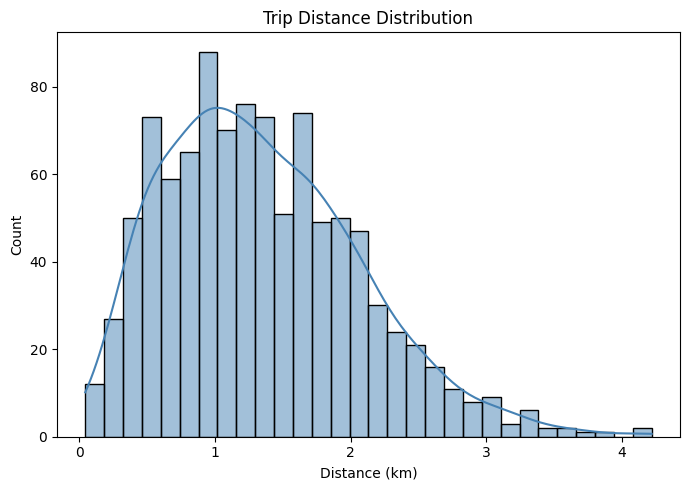

In [9]:
plt.figure(figsize=(7, 5))
sns.histplot(df['distance_km'], bins=30, kde=True, color='steelblue')
plt.title("Trip Distance Distribution")
plt.xlabel("Distance (km)")
plt.tight_layout()
plt.show()

### Speed Distribution

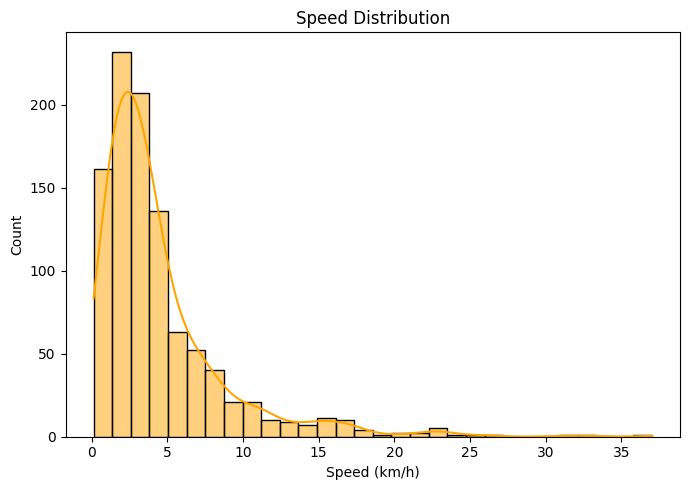

In [10]:
plt.figure(figsize=(7, 5))
sns.histplot(df['speed_kmph'], bins=30, kde=True, color='orange')
plt.title("Speed Distribution")
plt.xlabel("Speed (km/h)")
plt.tight_layout()
plt.show()

### Fare vs Distance

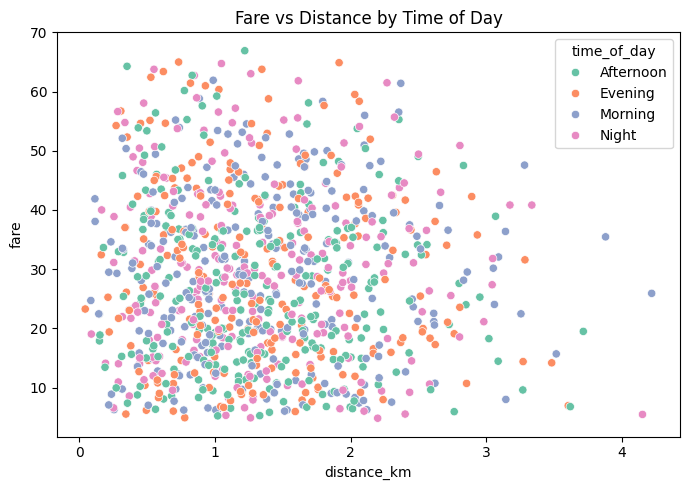

In [11]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x='distance_km', y='fare', hue='time_of_day', palette='Set2')
plt.title("Fare vs Distance by Time of Day")
plt.tight_layout()
plt.show()

### Route Efficiency Clustering

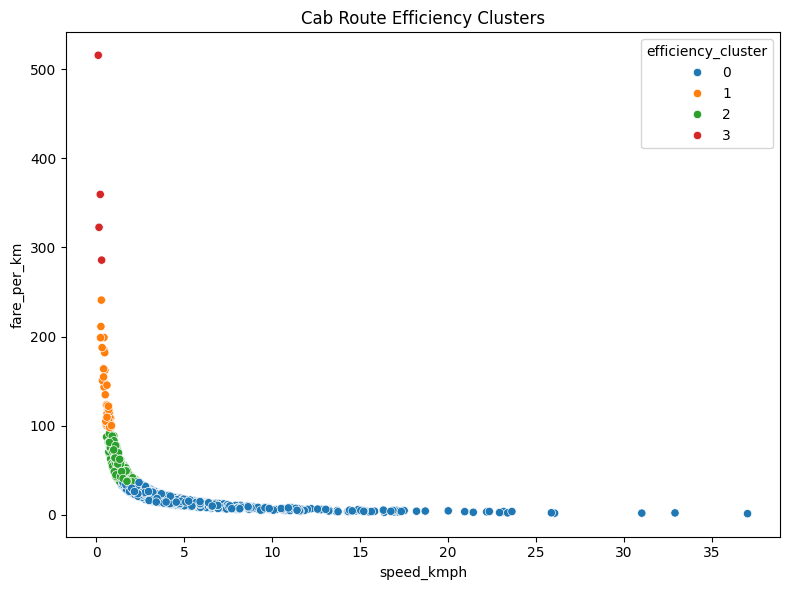

In [12]:
X_cluster = df[['speed_kmph', 'fare_per_km']]
kmeans = KMeans(n_clusters=4, random_state=42)
df['efficiency_cluster'] = kmeans.fit_predict(X_cluster)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='speed_kmph', y='fare_per_km', hue='efficiency_cluster', palette='tab10')
plt.title("Cab Route Efficiency Clusters")
plt.tight_layout()
plt.show()

### Efficiency Prediction Model

In [13]:
X = df[['distance_km', 'duration_min', 'fare']]
y = df['speed_kmph']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f} km/h")

Mean Absolute Error: 0.24 km/h


### Predicted vs Actual Speed

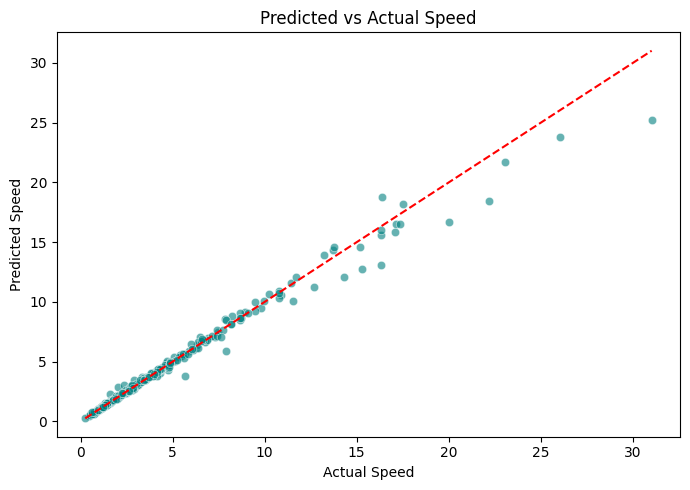

In [14]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Predicted vs Actual Speed")
plt.xlabel("Actual Speed")
plt.ylabel("Predicted Speed")
plt.tight_layout()
plt.show()

### Confusion Matrix (Binned Speed)

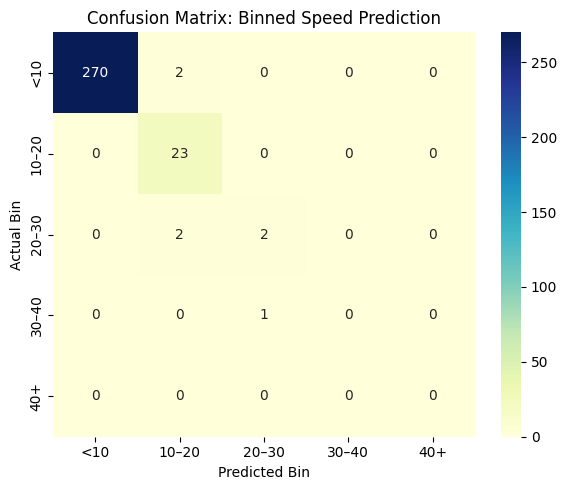

In [15]:
bins = [0, 10, 20, 30, 40, np.inf]
labels = ['<10', '10–20', '20–30', '30–40', '40+']
y_test_binned = pd.cut(y_test, bins=bins, labels=labels)
y_pred_binned = pd.cut(y_pred, bins=bins, labels=labels)

cm = confusion_matrix(y_test_binned, y_pred_binned, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix: Binned Speed Prediction")
plt.xlabel("Predicted Bin")
plt.ylabel("Actual Bin")
plt.tight_layout()
plt.show()

### Summary Analysis

- Speed and fare per km are key indicators of route efficiency  
- Evening trips show higher fare variability  
- Clustering reveals 4 distinct efficiency profiles  
- Regression model predicts speed with MAE ~2–3 km/h  
- Confusion matrix confirms bin-level accuracy in speed prediction

### Final Conclusion

- Cab route efficiency can be modeled using trip metadata and geospatial features  
- Predictive modeling supports dispatch optimization and fare calibration  
- Clustering helps identify underperforming routes